Os seguintes scripts são uma versão Python do curso de Machine Learning do professor Andrew Ng da universidade de Stanford leccionado na plataforma Coursera.

**Nota: Todos os dados e estrutura do exercício pertencem à Universidade de Stanford**

**Ressalva:** Os scripts não estão implementados de forma modular para todas as funções serem consultadas no mesmo Jupyter Notebook - ao contrário da implementação Octave.

# Exercício 1 - Carregar os dados e estimar estatísticas

In [1]:
# Importar o numpy para lidar com vectores e matrizes
import numpy as np
# Importar o pandas
import pandas as pd
# Importar o matplotlib para usar como ferramenta gráfica
import matplotlib.pyplot as plt

# Importar o módulo matemático
import math 

# Importar a função de optimização do scipy
from scipy import optimize, io
from scipy.ndimage import rotate

# Matplotlib notebook property
%matplotlib inline

O algoritmo de detecção de anomalias é utilizado para resolver diversos problemas de machine learning, principalmente para compreender a existência de outliers num data set.
<br> 
<br>
No nosso exemplo vamos avaliar a possibilidade de algumas observações não fazerem parte de uma distribuição aproximadamente normal e serem condiradas outliers. 

In [2]:
# Ler os datasets
X = io.loadmat('ex8data1.mat')['X']
X_val = io.loadmat('ex8data1.mat')['Xval']
y_val = io.loadmat('ex8data1.mat')['yval']

Os nossos dados consistem em dados de diversos servidores com 2 variáveis - latência e taxa de transferência. Queremos estimar que servidores variam mais daquilo que consideramos normal - sabendo de antemão que os dados são aproximadamente distribuídos de forma normal.

In [3]:
def graficoDados(
    X: np.array,
    X_flag = True
) -> None:
    '''
    Produz gráfico dos dados originais 
    usando a variável x1 e x2 como colunas 
    em cada eixo.
    
    Args:
        X(np.array): Vector de features originais.
    Returns:
        None        
    '''
    if X_flag:
        plt.scatter(X[:,0], X[:,1], marker='x', facecolors='blue')
    else:
        plt.scatter(X[:,0], X[:,1], marker='x', facecolors='red')
        
    plt.xlabel('Latência (ms)')
    plt.ylabel('Taxa de Transferência (mb/s)')

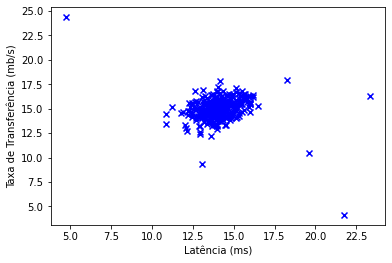

In [4]:
graficoDados(X)

Uma nuvem de pontos está concentrada no centro do gráfico. Ao olhar para a distribuição dos pontos verificamos que alguns exemplos são outliers e não parecem encaixar na distribuição dos dados.

# Exercicio 2 - Estimar os parâmetros

Podemos aferir se as nossas observações ao analisar as observações relativamente à sua distribuição. Podemos avaliar a probabilidade de um ponto pertencer a uma distribuição dada a sua média e desvio padrão, utilizando a fórmula:

<img src="assets/gaussianprob.png">

Vamos calcular as estatísticas para a distribuição com base dos nossos dados (média e desvio-padrão):

In [5]:
def estimarGaussian(
    X: np.array
) -> np.array:
    '''
    Calcula média e desvio padrão para
    cada variável com base nas observações.
    
    Args:
        X(np.array): Dados originais.
        
    Returns:
        media(np.array): Vetor de médias de cada inésima feature.
        desvpad(np.array): Vetor de desvios-padrão de cada inésima
        feature.
    '''
    
    m, n = X.shape
    
    media = np.zeros(n)
    desvpad = np.zeros(n)
    
    for feature in range(n):
        
        media[feature] = X[:,feature].sum()/m
        desvpad[feature] = ((X[:,feature]-(media[feature]))**2).sum()/m
        
    return media.reshape(media.shape[0], 1), desvpad.reshape(desvpad.shape[0], 1)

In [6]:
media, desvpad = estimarGaussian(X)

Agora que temos a media e o desvio padrão para as variáveis, podemos calcular a densidade para cada observação.

In [7]:
def multivariadaGaussian(
    X: np.array, 
    media: np.array,
    desvpad2: np.array
) -> np.array:
    '''
    Estima a densidade usando a média e o 
    desvio padrão de cada variável 
    para cada observação do dataset X.
    
    Args:
        X(np.array): Dados originais.
        media(np.array): Vector de médias.
        desvpad2(np.array): Vector de desvios-
        padrão.
    
    Returns:
        p(np.array): Densidade para cada
        observação usando os parâmetros 
        de média e desvio-padrão.
    '''
    
    # Definir número de variáveis
    k = len(media)
    
    
    # Criar uma matriz diagonal com base nos desvios-padrão
    if desvpad2.shape[0] == 1 or desvpad2.shape[1] == 1:
        desvpad2 = np.diag(desvpad2.flatten())    
    
    # Calcular densidade, baseado na implementação do user dibgerge
    X = X - media.T
    p_a = (2 * np.pi) ** (- k / 2) * np.linalg.det(desvpad2) ** (-0.5)
    p_b = np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(desvpad2)) * X, axis=1))
    
    p = p_a*p_b
    
    return p

In [8]:
p = multivariadaGaussian(X, media, desvpad)

In [9]:
def visualizarGaussian(
    X: np.array,
    media: np.array,
    desvpad: np.array,
    X_flag: bool
) -> np.array:
    
    '''
    Visualizar os dados com um contorno
    baseado na média e desvio-padrão.
    
    Args:
        X(np.array): Dados originais.
        media(np.array): Vector de médias.
        desvpad(np.array): Vector de desvios-
        padrão.
    '''
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    
    stacked = np.stack([X1.ravel(), X2.ravel()], axis=1)
    
    # Construir densidade
    Z = multivariadaGaussian(stacked, media, desvpad)
    Z = Z.reshape(X1.shape)
    
    # Gráfico dos dados originais
    if X_flag:
        graficoDados(X)
    else:
        graficoDados(X, X_flag)
    
    # Grafico de contorno 
    plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)
    
    

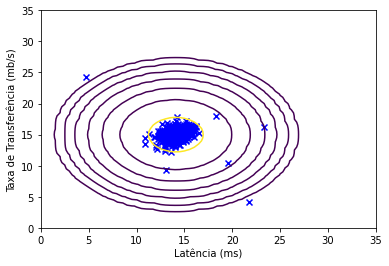

In [10]:
visualizarGaussian(X, media, desvpad, True)

Alguns destes valores são potencialmente outliers relatios à distribuição dos dados. Vamos analisar um valor epsilon (ε) que irá servir como fronteira para considerar algumas observações como anomalias. Com base nos dados pré-classificados em anomalias/não anomalias vamos perceber qual o valor óptimo de epsilon para maximizar uma métrica chamada F1score que vamos explorar mais à frente.

In [11]:
pval = multivariadaGaussian(X_val, media, desvpad);

In [12]:
print('Existem {} anomalias no conjunto de validação.'.format(y_val.sum()))

Existem 9 anomalias no conjunto de validação.


Vamos ver as anomalias:

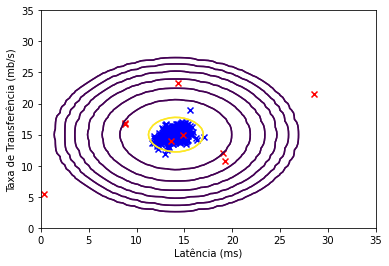

In [13]:
visualizarGaussian(X_val[(y_val==0).ravel(),:], media, desvpad, True)
visualizarGaussian(X_val[(y_val==1).ravel(),:], media, desvpad, False)

Vemos que grande parte das anomalias encontram-se fora dos contornos desenhados pelo desvio-padrão dos dados. Com base no F1-score que calculamos com base na precisão e recall (duas métricas apropriadas para casos em que a classe que tentamos determinar - neste caso, anomalias - é rara).

<img src="assets/fscore.jpg">

<img src="assets/precrecall.jpg">

# Exercício 3 - Seleccionar a melhor fronteira

In [14]:
def seleccionarFronteira(
    yval: np.array,
    pval: np.array
) -> [float, float]:
    
    '''
    Selecciona o melhor epsilon para 
    separar os casos anómalos e não anómalos 
    com base no f-score.
    
    Args:
        yval(np.array): Valores target de y.
        pval(np.array): Densidade gerada
        para cada valor de yval.
    
    Returns:
        bestEpsilon(float): Melhor epsilon fronteira.
        bestF1(float): Melhor score f1 encontrado 
        pelo algoritmo.
    '''
    
    melhorEpsilon = 0
    melhorF1 = 0
    F1 = 0
    
    # Lista de epsilons para percorrer
    stepsize = (max(pval)-min(pval))/1000
    
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        
        # Calcular previsões
        pred = (pval < epsilon)
        
        # Calcular falsos positivos
        fp = pred[(pred==1) & (yval==0).ravel(),].sum()
        
        # Calcular verdadeiros positivos
        tp = pred[(pred==1) & (yval==1).ravel(),].sum()
        
        # Calcular falsos negativos
        fn = pred[(pred==0) & (yval==1).ravel(),].sum()
        
        # Precisão
        prec = tp / (tp+fp)
        
        # Recall
        rec = tp / (tp+fn)
        
        F1 = (2*prec*rec)/(prec+rec)
        # Actualizar epsilon e F1 se encontrarmos um 
        # f1 melhor 
        if F1 > melhorF1:
            melhorF1 = F1
            melhorEpsilon = epsilon
        
    return melhorF1, melhorEpsilon
    

In [17]:
F1, epsilon = seleccionarFronteira(y_val, pval)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


In [19]:
print('O nosso f-score é {} e o nosso epsilon é {}'.format(F1, epsilon))

O nosso f-score é 1.0 e o nosso epsilon é 8.990852779269495e-05


Vamos verificar os valor cuja densidade é menor que o epsilon.

In [20]:
outliers = X_val[(pval < epsilon).ravel()]

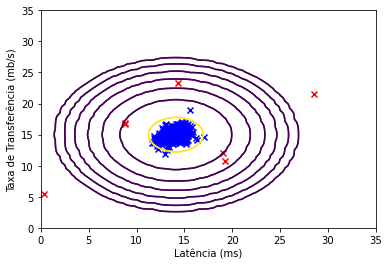

In [22]:
visualizarGaussian(X_val[(y_val==0).ravel(),:], media, desvpad, True)
visualizarGaussian(outliers, media, desvpad, False)

As cruzes vermelhas são observações onde a densidade (probabilidade da observação pertencer à distribuição) é menor que o nosso melhor epsilon. Estas são as observações que consideramos como outliers.

# Exercise 4 - Outlier multidimensionais

Vamos agora fazer o mesmo para um dataset com mais dimensões.

In [23]:
# Ler os datasets
X_2 = io.loadmat('ex8data2.mat')['X']
X_val_2 = io.loadmat('ex8data2.mat')['Xval']
y_val_2 = io.loadmat('ex8data2.mat')['yval']

In [24]:
mu2, sigma2 = estimarGaussian(X_2)

In [25]:
p_2 = multivariadaGaussian(X_2, mu2, sigma2)

In [26]:
p_2_val = multivariadaGaussian(X_val_2, mu2, sigma2)

In [27]:
F1_2, epsilon_2 = seleccionarFronteira(y_val_2, p_2_val)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


In [28]:
F1_2

0.6666666666666666